<a href="https://colab.research.google.com/github/ZahraDehghani99/FacemaskWearingAlertSystem/blob/main/FaceMaskClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Classifier

In [1]:
import os
import random
import cv2 as cv 
import numpy as np
import pandas as pd
from tqdm import tqdm
from sys import getsizeof
from imutils import paths
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display

from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Add, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array #
from tensorflow.keras.preprocessing.image import load_img #
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


check for GPU availablity

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
base_path = '/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/'
cdd_data_path = '/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/dataset_CDD/'
rmfd_data_path = '/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/dataset_RMFD/dataset_RMFD/'
smfd_data_path = '/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/dataset_SMFD/dataset_SMFD/'

## Data Visualization

In this project we use CDD, RMFD and SMFD datasets. Let's show 3 random images of each class in each dataset.

In the [prepare_dataset.ipynb](https://github.com/ZahraDehghani99/FacemaskWearingAlertSystem/blob/main/prepare_dataset.ipynb) we convert each dataset into npy format for images. In this notebook we load them and preprocess them.

In [ ]:
def visualize_data(data_name, npy_file_name, data_path):
  images = np.load(f'/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/{npy_file_name}.npy')

  with_mask_len = len(list(paths.list_images(data_path + "with_mask")))
  withou_mask_len = len(list(paths.list_images(data_path + "without_mask")))

  # let's select 3 random images form each class
  with_mask_idx = random.sample(range(with_mask_len), 3)
  without_mask_idx = random.sample(range(with_mask_len, with_mask_len + withou_mask_len), 3)

  cdd_data_with_mask = np.hstack([images[with_mask_idx[0]], images[with_mask_idx[1]], images[with_mask_idx[2]]]) 
  cdd_data_without_mask = np.hstack([images[without_mask_idx[0]], images[without_mask_idx[1]], images[without_mask_idx[2]]]) 

  print(f'{data_name} images with mask\n')
  cv2_imshow(cdd_data_with_mask)
  print(f'\n{data_name} images without mask\n')
  cv2_imshow(cdd_data_without_mask)
  

In [ ]:
!ls '/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/'

cdd_data.npy	dataset_RMFD	  dataset_SMFD.zip  smfd_data.npy
cdd_labels.npy	dataset_RMFD.zip  rmfd_data.npy     smfd_labels.npy
dataset_CDD	dataset_SMFD	  rmfd_labels.npy


CDD images with mask



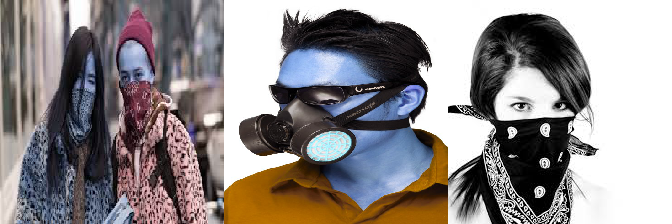


CDD images without mask



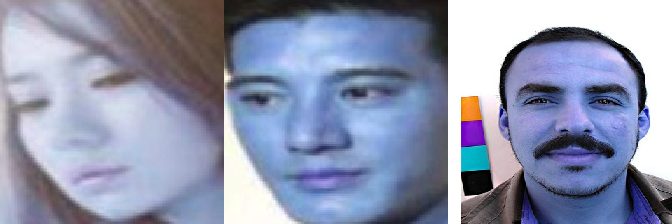

In [ ]:
visualize_data("CDD", "cdd_data", cdd_data_path)

RFMD images with mask



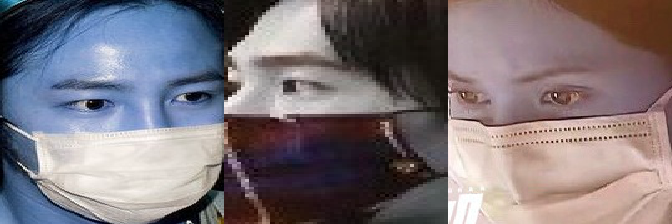


RFMD images without mask



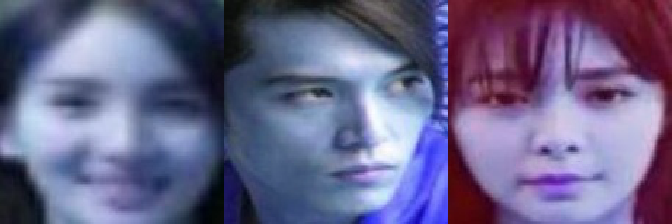

In [ ]:
visualize_data("RFMD", "rmfd_data", rmfd_data_path)

SMFD images with mask



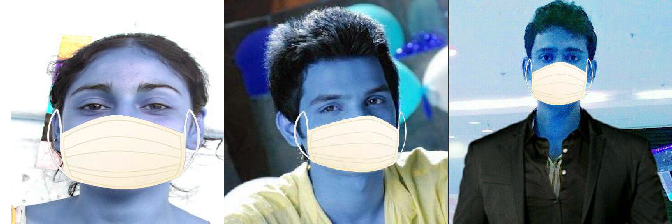


SMFD images without mask



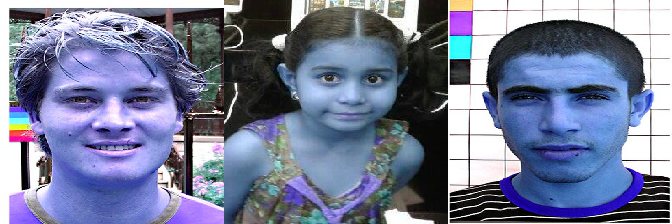

In [ ]:
visualize_data("SMFD", "smfd_data", smfd_data_path)

## Data preprocessing

In this section we used prepared npy files in the previous [prepare_dataset.ipynb](https://github.com/ZahraDehghani99/FacemaskWearingAlertSystem/blob/main/prepare_dataset.ipynb)  and preprocess them.

### Train test split for each dataset

#### CDD dataset

Becasue each data.npy file is 2.5 GB and we have limitation for RAM, we should load these files using `mmap_mode='c'`. It reduced the RAM usage.

In [ ]:
cdd_data = np.load(base_path + "cdd_data.npy", mmap_mode='c')
cdd_labels = np.load(base_path + "cdd_labels.npy", mmap_mode='c')

print(f'cdd data shape : {cdd_data.shape}')
print(f'cdd labels shape : {cdd_labels.shape}')

cdd data shape : (4092, 224, 224, 3)
cdd labels shape : (4092,)


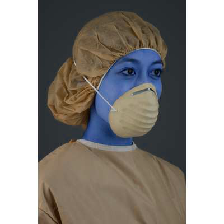

In [ ]:
cv2_imshow(cdd_data[0])

In [ ]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
X_train_cdd, X_test_cdd, y_train_cdd, y_test_cdd = train_test_split(cdd_data, cdd_labels, test_size=0.30, 
                                                                    stratify=cdd_labels, random_state=42)

print(f'X_train shape : {X_train_cdd.shape}')
print(f'X_test shape : {X_test_cdd.shape}')
print(f'y_train shape : {y_train_cdd.shape}')
print(f'y_test shape : {y_test_cdd.shape}')

X_train shape : (2864, 224, 224, 3)
X_test shape : (1228, 224, 224, 3)
y_train shape : (2864,)
y_test shape : (1228,)


In [ ]:
X_train_cdd = X_train_cdd / 255.0
X_test_cdd = X_test_cdd / 255.0

#### RMFD dataset

In [ ]:
rmfd_data = np.load(base_path + "rmfd_data.npy", mmap_mode='c')
rmfd_labels = np.load(base_path + "rmfd_labels.npy", mmap_mode='c')

print(f'rmfd data shape : {rmfd_data.shape}')
print(f'rmfd labels shape : {rmfd_labels.shape}')

rmfd data shape : (4406, 224, 224, 3)
rmfd labels shape : (4406,)


In [ ]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
X_train_rmfd, X_test_rmfd, y_train_rmfd, y_test_rmfd = train_test_split(rmfd_data, rmfd_labels, test_size=0.30, 
                                                                    stratify=rmfd_labels, random_state=42)

print(f'X_train shape : {X_train_rmfd.shape}')
print(f'X_test shape : {X_test_rmfd.shape}')
print(f'y_train shape : {y_train_rmfd.shape}')
print(f'y_test shape : {y_test_rmfd.shape}')

X_train shape : (3084, 224, 224, 3)
X_test shape : (1322, 224, 224, 3)
y_train shape : (3084,)
y_test shape : (1322,)


In [ ]:
X_train_rmfd = X_train_rmfd / 255.0
X_test_rmfd = X_test_rmfd / 255.0

#### SMFD dataset

In [ ]:
smfd_data = np.load(base_path + "smfd_data.npy", mmap_mode='c')
smfd_labels = np.load(base_path + "smfd_labels.npy", mmap_mode='c')

print(f'smfd data shape : {smfd_data.shape}')
print(f'smfd labels shape : {smfd_labels.shape}')

smfd data shape : (1376, 224, 224, 3)
smfd labels shape : (1376,)


In [ ]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
X_train_smfd, X_test_smfd, y_train_smfd, y_test_smfd = train_test_split(smfd_data, smfd_labels, test_size=0.30, 
                                                                    stratify=smfd_labels, random_state=42)

print(f'X_train shape : {X_train_smfd.shape}')
print(f'X_test shape : {X_test_smfd.shape}')
print(f'y_train shape : {y_train_smfd.shape}')
print(f'y_test shape : {y_test_smfd.shape}')

X_train shape : (963, 224, 224, 3)
X_test shape : (413, 224, 224, 3)
y_train shape : (963,)
y_test shape : (413,)


In [ ]:
X_train_smfd = X_train_smfd / 255.0
X_test_smfd = X_test_smfd / 255.0

#### Apeend All the X_trains (Stack X_trains)

In [ ]:
X_train = np.vstack([X_train_cdd, X_train_rmfd, X_train_smfd])
print(f'X_train shape : {X_train.shape}')

X_train shape : (6911, 224, 224, 3)


It's about 4 GB.

In [ ]:
print(f'X_train : {getsizeof(X_train)} Bytes')

X_train : 4161196184 Bytes


In [ ]:
# np.save(f'{base_path}/X_train.npy', X_train)

In [ ]:
y_train = np.hstack([y_train_cdd, y_train_rmfd, y_train_smfd])
print(f'y_train shape : {y_train.shape}')

y_train shape : (6911,)


In [ ]:
getsizeof(y_train)

331832

In [ ]:
# np.save(f'{base_path}/y_train.npy', y_train)

#### Save X_test s

let's save each X_test.

In [ ]:
# np.save(f'{base_path}/X_test_cdd.npy', X_test_cdd)
# np.save(f'{base_path}/X_test_rmfd.npy', X_test_rmfd)
# np.save(f'{base_path}/X_test_smfd.npy', X_test_smfd)

Let's save each y_test.

In [ ]:
# np.save(f'{base_path}/y_test_cdd.npy', y_test_cdd)
# np.save(f'{base_path}/y_test_rmfd.npy', y_test_rmfd)
# np.save(f'{base_path}/y_test_smfd.npy', y_test_smfd)

In [ ]:
getsizeof(X_test_cdd)

739393688

### Label Binarizer

Let's load saved datasets from drive.

In [5]:
X_train = np.load(base_path + "X_train.npy", mmap_mode='c')
y_train = np.load(base_path + "y_train.npy", mmap_mode='c')

In [6]:
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')

X_train shape : (6911, 224, 224, 3)
y_train shape : (6911,)


In [7]:
X_test_cdd = np.load(base_path + "X_test_cdd.npy", mmap_mode='c')
X_test_rmfd = np.load(base_path + "X_test_rmfd.npy", mmap_mode='c')
X_test_smfd = np.load(base_path + "X_test_smfd.npy", mmap_mode='c')

y_test_cdd = np.load(base_path + "y_test_cdd.npy", mmap_mode='c')
y_test_rmfd = np.load(base_path + "y_test_rmfd.npy", mmap_mode='c')
y_test_smfd = np.load(base_path + "y_test_smfd.npy", mmap_mode='c')

In [8]:
print(f'X_test_cdd shape : {X_test_cdd.shape}')
print(f'y_test_cdd shape : {y_test_cdd.shape}')
print(f'X_test_rmfd shape : {X_test_rmfd.shape}')
print(f'y_test_rmfd shape : {y_test_rmfd.shape}')
print(f'X_test_smfd shape : {X_test_smfd.shape}')
print(f'y_test_smfd shape : {y_test_smfd.shape}')

X_test_cdd shape : (1228, 224, 224, 3)
y_test_cdd shape : (1228,)
X_test_rmfd shape : (1322, 224, 224, 3)
y_test_rmfd shape : (1322,)
X_test_smfd shape : (413, 224, 224, 3)
y_test_smfd shape : (413,)


In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test_cdd = lb.transform(y_test_cdd)
y_test_rmfd = lb.transform(y_test_rmfd)
y_test_smfd = lb.transform(y_test_smfd)

y_train = to_categorical(y_train)
y_test_cdd = to_categorical(y_test_cdd)
y_test_rmfd = to_categorical(y_test_rmfd)
y_test_smfd = to_categorical(y_test_smfd)

In [10]:
print(f'y_train shape : {y_train.shape}')
print(f'y_test_cdd shape : {y_test_cdd.shape}')
print(f'y_test_rmfd shape : {y_test_rmfd.shape}')
print(f'y_test_smfd shape : {y_test_smfd.shape}')

y_train shape : (6911, 2)
y_test_cdd shape : (1228, 2)
y_test_rmfd shape : (1322, 2)
y_test_smfd shape : (413, 2)


In [11]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [12]:
inv =  lb.inverse_transform(np.array([0, 1]))
classes = []
for i in range(len(inv)):
  classes.append(inv[i])
  print(f'{inv[i]} => {i}')

with_mask => 0
without_mask => 1


## Train model

In [13]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 200
BS = 16

In [14]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [15]:
checkpointer = ModelCheckpoint(filepath= base_path + "model/best_model.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=10)

### Model Architecture

In [16]:
input_model = Input((224, 224, 3),name = 'input_layer')

conv1 = Conv2D(8, (7,7), padding="same", activation='relu',name = 'Conv1')(input_model)
bnorm1 = BatchNormalization(name = 'Bnorm1')(conv1)
avg1 = AveragePooling2D((2, 2), name = 'AvgPool1')(bnorm1) # if we don't set stirde , it's value set the same as kernel size


dw1 = SeparableConv2D(8, (5,5), padding="same", activation='relu', name= 'DW-Conv2')(avg1)
bnorm2 = BatchNormalization(name = 'Bnorm2')(dw1)
avg2 = AveragePooling2D((2, 2), name = 'AvgPool2')(bnorm2)


skip_connect1 = Conv2D(8, (1,1), strides=(4, 4), activation='relu',name = 'skip-connection1')(conv1)
bnorm_skip1 = BatchNormalization(name = 'Bnorm_skip1')(skip_connect1)
res1 = Add()([bnorm_skip1, avg2])


conv2 = Conv2D(32, (3,3), padding="same", activation='relu', name = 'Conv3')(res1) 
bnorm3 = BatchNormalization(name = 'Bnorm3')(conv2)
avg3 = AveragePooling2D((2, 2), name = 'AvgPool3')(bnorm3)


skip_connect2 = Conv2D(32, (1,1), strides=(2, 2), activation='relu',name = 'skip-connection2')(res1)
bnorm_skip2 = BatchNormalization(name = 'Bnorm_skip2')(skip_connect2)
res2 = Add()([bnorm_skip2, avg3])


dw2 = SeparableConv2D(64, (3,3), padding='same', activation='relu', name='DW-Conv4')(res2) 
bnorm4 = BatchNormalization(name = 'Bnorm4')(dw2)
avg4 = AveragePooling2D((2, 2), name = 'AvgPool4')(bnorm4)


skip_connect3 = Conv2D(64, (1,1), strides=(2, 2), activation='relu',name = 'skip-connection3')(res2)
bnorm_skip3 = BatchNormalization(name = 'Bnorm_skip3')(skip_connect3)
res3 = Add()([bnorm_skip3, avg4])


conv3 = Conv2D(128, (3,3), padding="same", activation='relu', name = 'Conv5')(res3) 
bnorm5 = BatchNormalization(name = 'Bnorm5')(conv3)


conv4 = Conv2D(2, (3,3), padding="same", activation='relu', name = 'Conv6')(conv3) 
bnorm6 = BatchNormalization(name = 'Bnorm6')(conv4)


skip_connect4 = Conv2D(2, (1,1), strides=(1, 1), activation='relu',name = 'skip-connection4')(res3)
bnorm_skip4 = BatchNormalization(name = 'Bnorm_skip4')(skip_connect4)
res4 = Add()([bnorm_skip4, bnorm6])


gavg = GlobalAveragePooling2D()(res4) 
output = Dense(units = 2, activation = 'softmax' , name='preds')(gavg)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 8)  1184        ['input_layer[0][0]']            
                                                                                                  
 Bnorm1 (BatchNormalization)    (None, 224, 224, 8)  32          ['Conv1[0][0]']                  
                                                                                                  
 AvgPool1 (AveragePooling2D)    (None, 112, 112, 8)  0           ['Bnorm1[0][0]']             

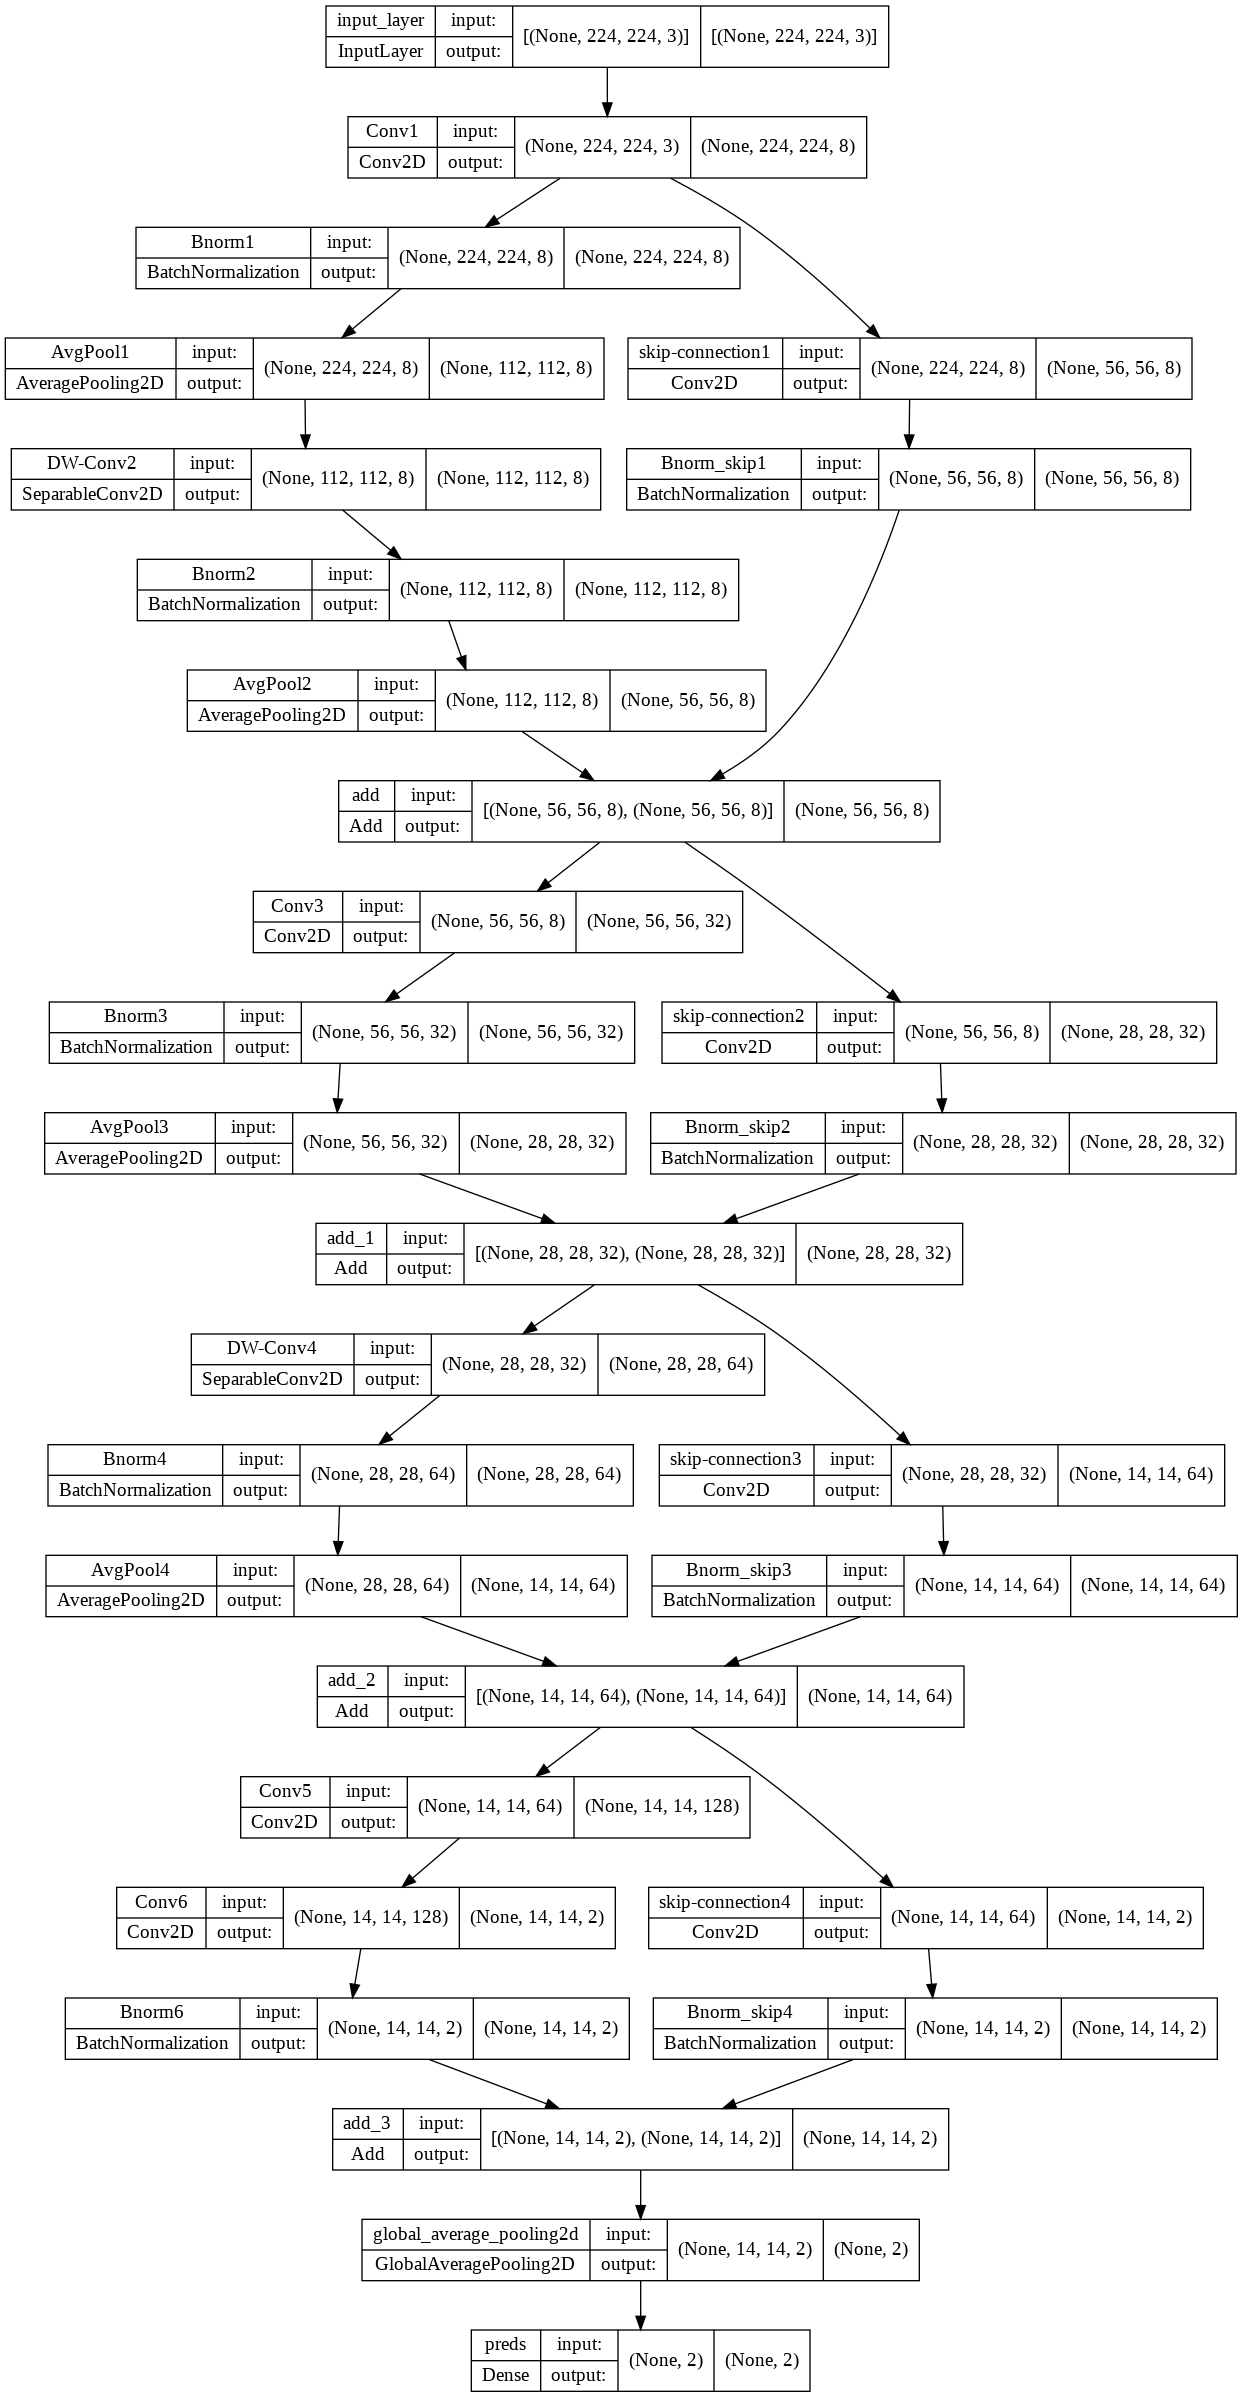

In [17]:
plot_model(model, show_shapes=True)

In [18]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [19]:
# train the model
print("[INFO] training model...")
history = model.fit(aug.flow(X_train, y_train, batch_size=BS),
										steps_per_epoch=len(X_train) // BS,
										validation_data=(X_test_rmfd, y_test_rmfd),
										epochs=EPOCHS, 
										callbacks=[checkpointer, reduce_lr])

model.save(base_path+"model/model_hist.h5")

[INFO] training model...
Epoch 1/200
431/431 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5395
Epoch 1: val_accuracy improved from -inf to 0.52799, saving model to /content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/model/best_model.hdf5
431/431 [==============================] - 142s 285ms/step - loss: 0.6882 - accuracy: 0.5395 - val_loss: 0.6812 - val_accuracy: 0.5280 - lr: 1.0000e-04
Epoch 2/200
431/431 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5585
Epoch 2: val_accuracy improved from 0.52799 to 0.69592, saving model to /content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/model/best_model.hdf5
431/431 [==============================] - 106s 246ms/step - loss: 0.6856 - accuracy: 0.5585 - val_loss: 0.6493 - val_accuracy: 0.6959 - lr: 1.0000e-04
Epoch 3/200
431/431 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5774
Epoch 3: val_accuracy improved from 0.69592 to 0.70726, savin

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")

model.save("/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/model/model2_hist.h5")

[INFO] saving mask detector model...


In [20]:
val_loss, loss = [], []

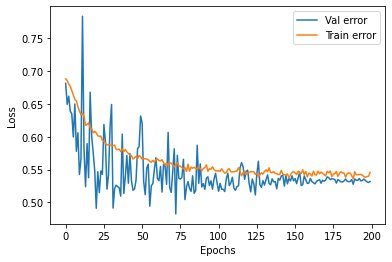

In [21]:
val_loss.extend(history.history['val_loss'])
loss.extend(history.history['loss'])

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()


In [22]:
val_accuracy, accuracy = [], []

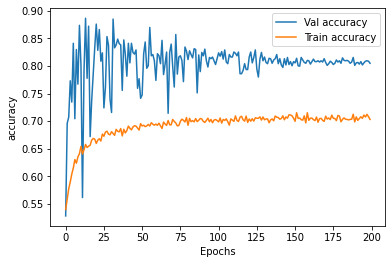

In [23]:
val_accuracy.extend(history.history['val_accuracy'])
accuracy.extend(history.history['accuracy'])

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

## Prediction

In [24]:
classID = ['with_mask', 'without_mask']

### CDD

let's load best model.

In [ ]:
from tensorflow import keras
model = keras.models.load_model(base_path + "model/best_model.hdf5")#

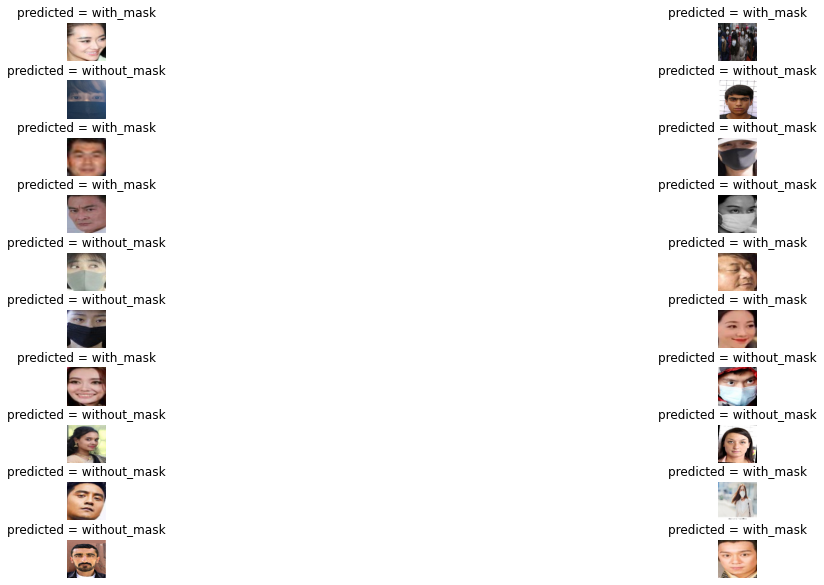

In [25]:
num = 20
idx = random.sample(range(X_test_cdd.shape[0]), 20)
test_list = []
for i in idx:
  test_list.append(X_test_cdd[i])
test_list = np.array(test_list)  

predict_test = model.predict(test_list)
predict_test_id = predict_test.argmax(axis=1) 

f = plt.figure(figsize=(20, 16))
for i in range(num):
    plt.subplot(num, 2, i+1)
    plt.imshow(test_list[i])
    plt.title(f'predicted = {classID[predict_test_id[i]]}')
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (30,3)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

### RMFD

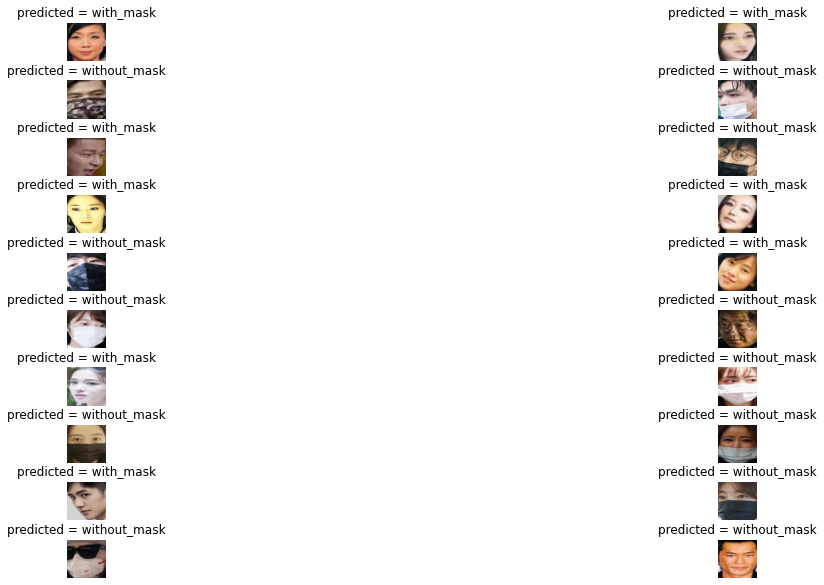

In [26]:
num = 20
idx = random.sample(range(X_test_rmfd.shape[0]), 20)
test_list = []
for i in idx:
  test_list.append(X_test_rmfd[i])
test_list = np.array(test_list)  

predict_test = model.predict(test_list)
predict_test_id = predict_test.argmax(axis=1) 

f = plt.figure(figsize=(20, 16))
for i in range(num):
    plt.subplot(num, 2, i+1)
    plt.imshow(test_list[i])
    plt.title(f'predicted = {classID[predict_test_id[i]]}')
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (30,3)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

### SMFD

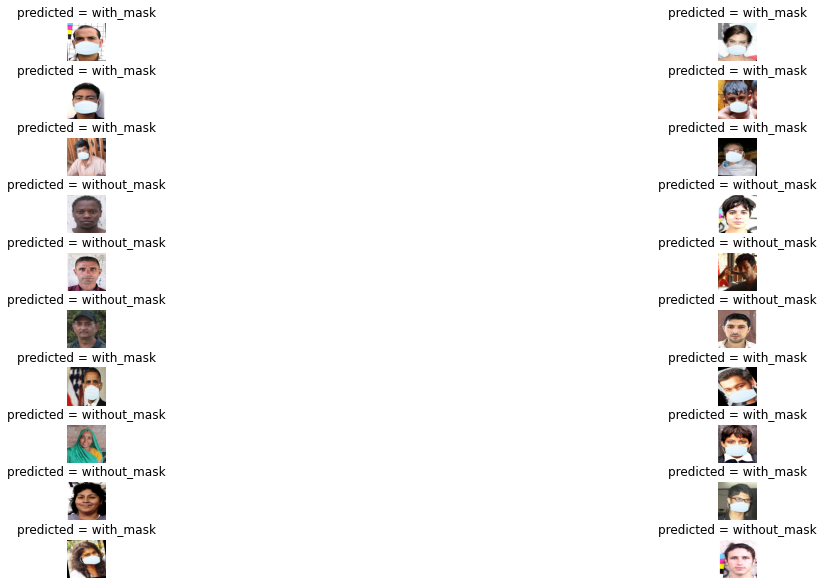

In [27]:
num = 20
idx = random.sample(range(X_test_smfd.shape[0]), 20)
test_list = []
for i in idx:
  test_list.append(X_test_smfd[i])
test_list = np.array(test_list)  

predict_test = model.predict(test_list)
predict_test_id = predict_test.argmax(axis=1) 

f = plt.figure(figsize=(20, 16))
for i in range(num):
    plt.subplot(num, 2, i+1)
    plt.imshow(test_list[i])
    plt.title(f'predicted = {classID[predict_test_id[i]]}')
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (30,3)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

## Confusion Matrix

In [28]:
def plot_confusion_matrix(y_test_id, pred_id):
  y_true = [classID[i] for i in y_test_id]
  y_pred = [classID[i] for i in pred_id]
  data = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (5,4))
  # sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### CDD

In [29]:
y_pred_cdd = model.predict(X_test_cdd)
print(f'y_pred_cdd : {y_pred_cdd}')
pred_id_cdd = np.argmax(y_pred_cdd, axis=1)
print(f'pred_id_cdd : {pred_id_cdd}')

y_pred_cdd : [[0.8788099  0.12119006]
 [0.87780476 0.12219518]
 [0.12273392 0.8772661 ]
 ...
 [0.5428594  0.45714068]
 [0.8508598  0.14914018]
 [0.6012829  0.39871714]]
pred_id_cdd : [0 0 1 ... 0 0 0]


In [30]:
y_test_id_cdd = np.argmax(y_test_cdd, axis=1)
print(f'y_test_id_cdd : {y_test_id_cdd}')


y_test_id_cdd : [1 0 0 ... 1 1 1]


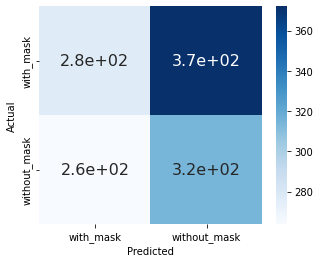

In [31]:
plot_confusion_matrix(y_test_id_cdd, pred_id_cdd)

In [32]:
print(classification_report(y_test_id_cdd, pred_id_cdd, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.51      0.43      0.47       649
without_mask       0.46      0.54      0.50       579

    accuracy                           0.48      1228
   macro avg       0.49      0.49      0.48      1228
weighted avg       0.49      0.48      0.48      1228



### RMFD

In [33]:
y_pred_rmfd = model.predict(X_test_rmfd)
print(f'y_pred_rmfd : {y_pred_rmfd}')
pred_id_rmfd = np.argmax(y_pred_rmfd, axis=1)
print(f'pred_id_rmfd : {pred_id_rmfd}')

y_pred_rmfd : [[0.11311226 0.8868877 ]
 [0.9170173  0.0829827 ]
 [0.4288404  0.57115954]
 ...
 [0.1589546  0.84104544]
 [0.1978511  0.8021489 ]
 [0.12273373 0.8772663 ]]
pred_id_rmfd : [1 0 1 ... 1 1 1]


In [34]:
y_test_id_rmfd = np.argmax(y_test_rmfd, axis=1)
print(f'y_test_id_rmfd : {y_test_id_rmfd}')


y_test_id_rmfd : [1 0 1 ... 1 1 1]


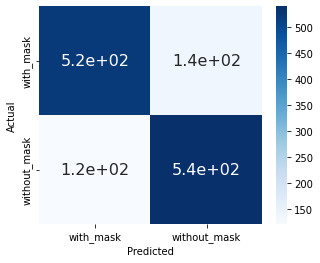

In [35]:
plot_confusion_matrix(y_test_id_rmfd, pred_id_rmfd)

In [36]:
print(classification_report(y_test_id_rmfd, pred_id_rmfd, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.81      0.79      0.80       661
without_mask       0.80      0.82      0.81       661

    accuracy                           0.80      1322
   macro avg       0.81      0.80      0.80      1322
weighted avg       0.81      0.80      0.80      1322



### SMFD

In [37]:
y_pred_smfd = model.predict(X_test_smfd)
print(f'y_pred_smfd : {y_pred_smfd}')
pred_id_smfd = np.argmax(y_pred_smfd, axis=1)
print(f'pred_id_smfd : {pred_id_smfd}')

y_pred_smfd : [[9.28182483e-01 7.18174726e-02]
 [9.99971032e-01 2.89715517e-05]
 [9.99980092e-01 1.98618727e-05]
 [2.90208985e-03 9.97097969e-01]
 [9.89188135e-01 1.08118467e-02]
 [9.81770813e-01 1.82292089e-02]
 [9.99630928e-01 3.69113783e-04]
 [1.74747109e-02 9.82525229e-01]
 [9.99947548e-01 5.24584684e-05]
 [2.80358014e-03 9.97196436e-01]
 [9.89283860e-01 1.07160872e-02]
 [6.86314702e-01 3.13685328e-01]
 [2.97905564e-01 7.02094495e-01]
 [4.36517689e-03 9.95634854e-01]
 [6.72502071e-02 9.32749808e-01]
 [2.49818459e-01 7.50181556e-01]
 [7.18606189e-02 9.28139389e-01]
 [6.04526401e-01 3.95473540e-01]
 [7.81628415e-02 9.21837091e-01]
 [9.99908447e-01 9.14951233e-05]
 [1.23731345e-02 9.87626851e-01]
 [2.79533211e-03 9.97204602e-01]
 [4.53300169e-03 9.95466948e-01]
 [9.99651432e-01 3.48598958e-04]
 [4.42715660e-02 9.55728412e-01]
 [6.41553164e-01 3.58446836e-01]
 [7.57220387e-01 2.42779627e-01]
 [1.61070284e-02 9.83892918e-01]
 [9.99913573e-01 8.64688045e-05]
 [1.04213329e-02 9.89578664e-

In [38]:
y_test_id_smfd = np.argmax(y_test_smfd, axis=1)
print(f'y_test_id_smfd : {y_test_id_smfd}')


y_test_id_smfd : [1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0
 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0
 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0
 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1
 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1
 1 0 1 1 0 1]


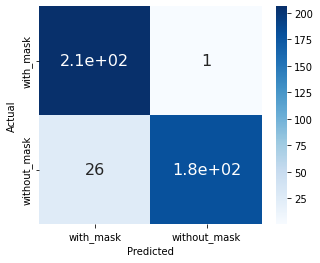

In [39]:
plot_confusion_matrix(y_test_id_smfd, pred_id_smfd)

In [40]:
print(classification_report(y_test_id_smfd, pred_id_smfd, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.89      1.00      0.94       207
without_mask       0.99      0.87      0.93       206

    accuracy                           0.93       413
   macro avg       0.94      0.93      0.93       413
weighted avg       0.94      0.93      0.93       413



### Best Model

In [41]:
from tensorflow import keras
model = keras.models.load_model(base_path + "model/best_model.hdf5")#

### CDD

In [42]:
y_pred_cdd = model.predict(X_test_cdd)
print(f'y_pred_cdd : {y_pred_cdd}')
pred_id_cdd = np.argmax(y_pred_cdd, axis=1)
print(f'pred_id_cdd : {pred_id_cdd}')

y_pred_cdd : [[0.7538205  0.2461795 ]
 [0.5825752  0.4174248 ]
 [0.14842772 0.8515723 ]
 ...
 [0.64617664 0.35382333]
 [0.74913335 0.25086668]
 [0.727932   0.27206802]]
pred_id_cdd : [0 0 1 ... 0 0 0]


In [43]:
y_test_id_cdd = np.argmax(y_test_cdd, axis=1)
print(f'y_test_id_cdd : {y_test_id_cdd}')


y_test_id_cdd : [1 0 0 ... 1 1 1]


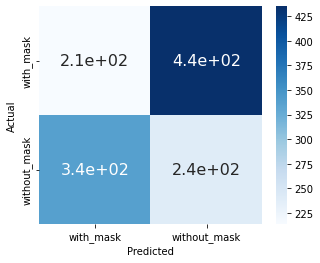

In [44]:
plot_confusion_matrix(y_test_id_cdd, pred_id_cdd)

In [45]:
print(classification_report(y_test_id_cdd, pred_id_cdd, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.39      0.33      0.36       649
without_mask       0.36      0.41      0.38       579

    accuracy                           0.37      1228
   macro avg       0.37      0.37      0.37      1228
weighted avg       0.37      0.37      0.37      1228



### RMFD

In [46]:
y_pred_rmfd = model.predict(X_test_rmfd)
print(f'y_pred_rmfd : {y_pred_rmfd}')
pred_id_rmfd = np.argmax(y_pred_rmfd, axis=1)
print(f'pred_id_rmfd : {pred_id_rmfd}')

y_pred_rmfd : [[0.23218417 0.7678158 ]
 [0.7468152  0.25318474]
 [0.37543124 0.62456876]
 ...
 [0.3082668  0.69173324]
 [0.29425153 0.70574844]
 [0.14842774 0.8515723 ]]
pred_id_rmfd : [1 0 1 ... 1 1 1]


In [47]:
y_test_id_rmfd = np.argmax(y_test_rmfd, axis=1)
print(f'y_test_id_rmfd : {y_test_id_rmfd}')


y_test_id_rmfd : [1 0 1 ... 1 1 1]


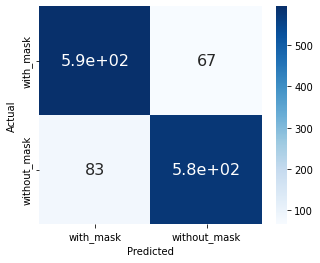

In [48]:
plot_confusion_matrix(y_test_id_rmfd, pred_id_rmfd)

In [49]:
print(classification_report(y_test_id_rmfd, pred_id_rmfd, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.88      0.90      0.89       661
without_mask       0.90      0.87      0.89       661

    accuracy                           0.89      1322
   macro avg       0.89      0.89      0.89      1322
weighted avg       0.89      0.89      0.89      1322



### SMFD

In [50]:
y_pred_smfd = model.predict(X_test_smfd)
print(f'y_pred_smfd : {y_pred_smfd}')
pred_id_smfd = np.argmax(y_pred_smfd, axis=1)
print(f'pred_id_smfd : {pred_id_smfd}')

y_pred_smfd : [[0.7767743  0.22322571]
 [0.94245225 0.05754777]
 [0.9707253  0.02927469]
 [0.06650235 0.93349767]
 [0.55362374 0.44637626]
 [0.8499147  0.15008526]
 [0.5811651  0.41883492]
 [0.22615193 0.7738481 ]
 [0.9005214  0.09947857]
 [0.08669344 0.91330653]
 [0.6015429  0.39845708]
 [0.6098186  0.3901814 ]
 [0.27996558 0.72003436]
 [0.15368208 0.8463179 ]
 [0.15218978 0.8478102 ]
 [0.15384276 0.8461572 ]
 [0.23501162 0.7649884 ]
 [0.5194447  0.48055533]
 [0.3215189  0.6784811 ]
 [0.9888644  0.01113558]
 [0.09682816 0.9031719 ]
 [0.06694686 0.9330532 ]
 [0.04422791 0.9557721 ]
 [0.8985052  0.1014948 ]
 [0.07976808 0.92023194]
 [0.77645725 0.22354273]
 [0.27271986 0.7272801 ]
 [0.2522934  0.7477066 ]
 [0.922097   0.07790302]
 [0.23415262 0.7658474 ]
 [0.10580871 0.8941913 ]
 [0.5818553  0.41814473]
 [0.73508584 0.26491416]
 [0.08926402 0.91073596]
 [0.66056246 0.3394375 ]
 [0.9953609  0.00463911]
 [0.99580234 0.00419768]
 [0.660393   0.33960694]
 [0.79026294 0.20973709]
 [0.0797369

In [ ]:
y_test_id_smfd = np.argmax(y_test_smfd, axis=1)
print(f'y_test_id_smfd : {y_test_id_smfd}')


y_test_id_smfd : [1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0
 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0
 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0
 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1
 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1
 1 0 1 1 0 1]


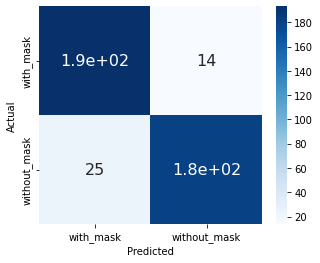

In [51]:
plot_confusion_matrix(y_test_id_smfd, pred_id_smfd)

In [52]:
print(classification_report(y_test_id_smfd, pred_id_smfd, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.89      0.93      0.91       207
without_mask       0.93      0.88      0.90       206

    accuracy                           0.91       413
   macro avg       0.91      0.91      0.91       413
weighted avg       0.91      0.91      0.91       413

